- I studied with notebook below. <br>
https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

## Data Loading

In [1]:
import os

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
os.listdir('../input/cassava-leaf-disease-classification')

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
label_map = pd.read_json('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json', orient='index')

display(train.head())
display(test.head())
display(label_map)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


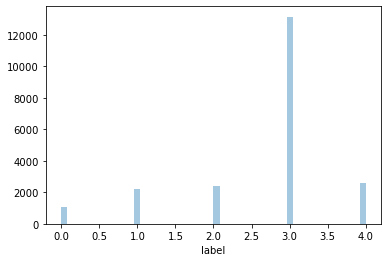

In [4]:
sns.distplot(train['label'], kde=False)

## Directory Settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
TRAIN_PATH = '../input/cassava-leaf-disease-classification/train_images'
TEST_PATH = '../input/cassava-leaf-disease-classification/test_images'

## CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    model_name='resnext50_32x4d'
    size=256
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=10
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=5
    target_col='label'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    inference=False
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

## Library

In [7]:
!pip install timm

     |████████████████████████████████| 244 kB 866 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
    
from albumentations.pytorch import ToTensorV2

from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')
    
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

## CV split

In [10]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
    
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


## Dataset

In [11]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        '''
        그림BGR = cv2.imread("그림파일.jpg")
        그림RGB = cv2.cvtColor(그림BGR, cv2.COLOR_BGR2RGB)
        '''
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        
        return image, label
    
    
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):    
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        return image

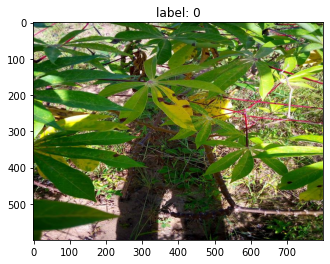

In [12]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show()

## Transforms

> Question

how did you get the values of Normalize(mean=[…], std=[…])?

> Answer

You have to iterate over the dataset calculating the mean and the std.

For simplicity we will do this with a example batch. First you have to transform your batch of images with size [b_size, channels, x, y] into [b_size, channels, x*y], like flattening the image. Then you calculate the mean value of each image and when you have those values you add them along the b_size axis. If you do that you will get the mean value of each channel in the batch. Knowing this you have to change it to do over the whole dataset.

If you do the same but using std you get the std of each channel.

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

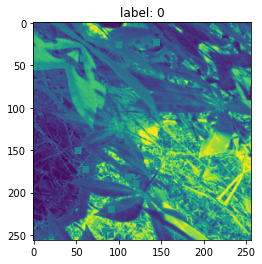

In [14]:
train_dataset = TrainDataset(train, transform = get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

## Model

In [15]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        
        return x

In [16]:
# MODEL
model = CustomResNext(model_name=CFG.model_name, pretrained=False)

# DATASET
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

# DATALOADER
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.1924,  0.0310,  0.0261,  0.2754, -0.1179],
        [ 0.1809,  0.1283,  0.0761,  0.7103,  0.1158],
        [ 0.0869,  0.1180,  0.0543,  0.4261,  0.0353],
        [ 0.0742, -0.0484,  0.1194,  0.4222,  0.1329]],
       grad_fn=<AddmmBackward>)


## Helper functions

In [17]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    
    return probs

## Train loop

In [18]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [19]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.inference:
        # inference
        model = CustomResNext(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                 num_workers=CFG.num_workers, pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

In [20]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50_32x4d_ra-d733960d.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d_ra-d733960d.pth


Epoch: [1][0/534] Data 1.679 (1.679) Elapsed 0m 3s (remain 30m 33s) Loss: 1.5482(1.5482) Grad: 8.1059  
Epoch: [1][100/534] Data 0.000 (0.017) Elapsed 0m 43s (remain 3m 4s) Loss: 0.8025(0.8247) Grad: 13.6389  
Epoch: [1][200/534] Data 0.010 (0.009) Elapsed 1m 23s (remain 2m 17s) Loss: 0.3008(0.7297) Grad: 5.0669  
Epoch: [1][300/534] Data 0.000 (0.006) Elapsed 2m 2s (remain 1m 34s) Loss: 0.5419(0.6751) Grad: 8.3931  
Epoch: [1][400/534] Data 0.000 (0.005) Elapsed 2m 42s (remain 0m 53s) Loss: 0.5032(0.6444) Grad: 6.1452  
Epoch: [1][500/534] Data 0.000 (0.004) Elapsed 3m 22s (remain 0m 13s) Loss: 0.4588(0.6265) Grad: 6.6259  
Epoch: [1][533/534] Data 0.000 (0.004) Elapsed 3m 34s (remain 0m 0s) Loss: 0.7242(0.6192) Grad: 7.8318  
EVAL: [0/134] Data 1.119 (1.119) Elapsed 0m 1s (remain 2m 41s) Loss: 0.7604(0.7604) 
EVAL: [100/134] Data 0.080 (0.181) Elapsed 0m 28s (remain 0m 9s) Loss: 0.6971(0.5087) 


Epoch 1 - avg_train_loss: 0.6192  avg_val_loss: 0.5073  time: 252s
Epoch 1 - Accuracy: 0.8257009345794393
Epoch 1 - Save Best Score: 0.8257 Model


EVAL: [133/134] Data 0.010 (0.178) Elapsed 0m 36s (remain 0m 0s) Loss: 0.6232(0.5073) 
Epoch: [2][0/534] Data 1.306 (1.306) Elapsed 0m 1s (remain 15m 22s) Loss: 0.5518(0.5518) Grad: 6.3776  
Epoch: [2][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.2913(0.5023) Grad: 4.5230  
Epoch: [2][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.4416(0.4976) Grad: 4.8117  
Epoch: [2][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4326(0.4863) Grad: 5.9154  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.6340(0.4823) Grad: 7.6833  
Epoch: [2][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.5841(0.4887) Grad: 6.4603  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 29s (remain 0m 0s) Loss: 0.3496(0.4863) Grad: 4.8970  
EVAL: [0/134] Data 1.066 (1.066) Elapsed 0m 1s (remain 2m 35s) Loss: 0.5970(0.5970) 
EVAL: [100/134] Data 0.373 (0.166) Elapsed 0m 26s (remain 0m 8s) Loss: 0.5517(0.4612) 


Epoch 2 - avg_train_loss: 0.4863  avg_val_loss: 0.4591  time: 244s
Epoch 2 - Accuracy: 0.8523364485981308
Epoch 2 - Save Best Score: 0.8523 Model


EVAL: [133/134] Data 0.000 (0.157) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6488(0.4591) 
Epoch: [3][0/534] Data 1.984 (1.984) Elapsed 0m 2s (remain 21m 34s) Loss: 0.3097(0.3097) Grad: 4.5447  
Epoch: [3][100/534] Data 0.000 (0.020) Elapsed 0m 41s (remain 2m 58s) Loss: 0.3355(0.4390) Grad: 4.5280  
Epoch: [3][200/534] Data 0.000 (0.010) Elapsed 1m 20s (remain 2m 13s) Loss: 0.4168(0.4455) Grad: 4.9605  
Epoch: [3][300/534] Data 0.000 (0.007) Elapsed 1m 59s (remain 1m 32s) Loss: 0.3815(0.4582) Grad: 4.8842  
Epoch: [3][400/534] Data 0.000 (0.006) Elapsed 2m 38s (remain 0m 52s) Loss: 0.2566(0.4557) Grad: 2.9273  
Epoch: [3][500/534] Data 0.000 (0.005) Elapsed 3m 17s (remain 0m 13s) Loss: 0.6674(0.4558) Grad: 6.8415  
Epoch: [3][533/534] Data 0.000 (0.004) Elapsed 3m 30s (remain 0m 0s) Loss: 0.5766(0.4593) Grad: 5.4368  
EVAL: [0/134] Data 1.330 (1.330) Elapsed 0m 1s (remain 3m 10s) Loss: 0.5733(0.5733) 
EVAL: [100/134] Data 0.597 (0.166) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4595(0.4393) 


Epoch 3 - avg_train_loss: 0.4593  avg_val_loss: 0.4360  time: 244s
Epoch 3 - Accuracy: 0.8558411214953271
Epoch 3 - Save Best Score: 0.8558 Model


EVAL: [133/134] Data 0.060 (0.156) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6719(0.4360) 
Epoch: [4][0/534] Data 1.357 (1.357) Elapsed 0m 1s (remain 15m 43s) Loss: 0.5742(0.5742) Grad: 4.7767  
Epoch: [4][100/534] Data 0.000 (0.014) Elapsed 0m 40s (remain 2m 54s) Loss: 0.5604(0.4194) Grad: 5.6712  
Epoch: [4][200/534] Data 0.000 (0.007) Elapsed 1m 19s (remain 2m 11s) Loss: 0.4307(0.4295) Grad: 4.3769  
Epoch: [4][300/534] Data 0.000 (0.005) Elapsed 1m 58s (remain 1m 31s) Loss: 0.3070(0.4293) Grad: 4.1907  
Epoch: [4][400/534] Data 0.000 (0.004) Elapsed 2m 37s (remain 0m 52s) Loss: 0.3817(0.4279) Grad: 5.0044  
Epoch: [4][500/534] Data 0.000 (0.003) Elapsed 3m 16s (remain 0m 12s) Loss: 0.4414(0.4298) Grad: 4.8294  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 28s (remain 0m 0s) Loss: 0.6259(0.4281) Grad: 6.2169  
EVAL: [0/134] Data 1.085 (1.085) Elapsed 0m 1s (remain 2m 39s) Loss: 0.5437(0.5437) 
EVAL: [100/134] Data 0.538 (0.161) Elapsed 0m 26s (remain 0m 8s) Loss: 0.6238(0.4198) 


Epoch 4 - avg_train_loss: 0.4281  avg_val_loss: 0.4142  time: 243s
Epoch 4 - Accuracy: 0.860981308411215
Epoch 4 - Save Best Score: 0.8610 Model


EVAL: [133/134] Data 0.000 (0.155) Elapsed 0m 33s (remain 0m 0s) Loss: 0.6251(0.4142) 
Epoch: [5][0/534] Data 1.321 (1.321) Elapsed 0m 1s (remain 15m 45s) Loss: 0.2560(0.2560) Grad: 4.1736  
Epoch: [5][100/534] Data 0.000 (0.014) Elapsed 0m 40s (remain 2m 54s) Loss: 0.2739(0.3869) Grad: 4.7913  
Epoch: [5][200/534] Data 0.000 (0.007) Elapsed 1m 19s (remain 2m 11s) Loss: 0.4770(0.4016) Grad: 4.4494  
Epoch: [5][300/534] Data 0.007 (0.005) Elapsed 1m 58s (remain 1m 31s) Loss: 0.5418(0.4145) Grad: 5.4747  
Epoch: [5][400/534] Data 0.000 (0.004) Elapsed 2m 37s (remain 0m 52s) Loss: 0.5379(0.4074) Grad: 4.9700  
Epoch: [5][500/534] Data 0.000 (0.003) Elapsed 3m 16s (remain 0m 12s) Loss: 0.4458(0.4031) Grad: 5.8221  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 28s (remain 0m 0s) Loss: 1.0044(0.4002) Grad: 7.6199  
EVAL: [0/134] Data 1.110 (1.110) Elapsed 0m 1s (remain 2m 40s) Loss: 0.5071(0.5071) 
EVAL: [100/134] Data 0.567 (0.162) Elapsed 0m 26s (remain 0m 8s) Loss: 0.5755(0.4154) 


Epoch 5 - avg_train_loss: 0.4002  avg_val_loss: 0.4117  time: 243s
Epoch 5 - Accuracy: 0.8644859813084113
Epoch 5 - Save Best Score: 0.8645 Model


EVAL: [133/134] Data 0.000 (0.155) Elapsed 0m 33s (remain 0m 0s) Loss: 0.7064(0.4117) 
Epoch: [6][0/534] Data 1.254 (1.254) Elapsed 0m 1s (remain 15m 0s) Loss: 0.4236(0.4236) Grad: 5.9376  
Epoch: [6][100/534] Data 0.008 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.3406(0.3846) Grad: 4.3328  
Epoch: [6][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.8054(0.3801) Grad: 8.8393  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.5040(0.3785) Grad: 6.0667  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.2823(0.3791) Grad: 3.2562  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.4236(0.3836) Grad: 4.9651  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.1671(0.3854) Grad: 2.7937  
EVAL: [0/134] Data 1.161 (1.161) Elapsed 0m 1s (remain 2m 47s) Loss: 0.5028(0.5028) 
EVAL: [100/134] Data 0.553 (0.161) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4880(0.3921) 


Epoch 6 - avg_train_loss: 0.3854  avg_val_loss: 0.3891  time: 245s
Epoch 6 - Accuracy: 0.8707943925233644
Epoch 6 - Save Best Score: 0.8708 Model


EVAL: [133/134] Data 0.000 (0.157) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6694(0.3891) 
Epoch: [7][0/534] Data 1.270 (1.270) Elapsed 0m 1s (remain 15m 8s) Loss: 0.4135(0.4135) Grad: 5.3028  
Epoch: [7][100/534] Data 0.000 (0.013) Elapsed 0m 40s (remain 2m 55s) Loss: 0.2021(0.3553) Grad: 3.5405  
Epoch: [7][200/534] Data 0.000 (0.007) Elapsed 1m 19s (remain 2m 11s) Loss: 0.2172(0.3623) Grad: 4.4003  
Epoch: [7][300/534] Data 0.000 (0.005) Elapsed 1m 58s (remain 1m 31s) Loss: 0.5837(0.3601) Grad: 5.4313  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 2m 36s (remain 0m 51s) Loss: 0.1851(0.3608) Grad: 2.8125  
Epoch: [7][500/534] Data 0.000 (0.003) Elapsed 3m 15s (remain 0m 12s) Loss: 0.4159(0.3614) Grad: 6.0347  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 27s (remain 0m 0s) Loss: 0.5643(0.3614) Grad: 5.5326  
EVAL: [0/134] Data 1.120 (1.120) Elapsed 0m 1s (remain 2m 43s) Loss: 0.4214(0.4214) 
EVAL: [100/134] Data 0.345 (0.161) Elapsed 0m 26s (remain 0m 8s) Loss: 0.5442(0.4007) 


Epoch 7 - avg_train_loss: 0.3614  avg_val_loss: 0.3915  time: 242s
Epoch 7 - Accuracy: 0.8663551401869158


EVAL: [133/134] Data 0.000 (0.156) Elapsed 0m 33s (remain 0m 0s) Loss: 0.6143(0.3915) 
Epoch: [8][0/534] Data 1.296 (1.296) Elapsed 0m 1s (remain 15m 28s) Loss: 0.3624(0.3624) Grad: 4.4865  
Epoch: [8][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 56s) Loss: 0.3031(0.3189) Grad: 4.5279  
Epoch: [8][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.2724(0.3215) Grad: 3.2709  
Epoch: [8][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4358(0.3283) Grad: 7.1483  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.3629(0.3337) Grad: 5.5893  
Epoch: [8][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.2882(0.3362) Grad: 4.9387  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.1839(0.3381) Grad: 4.3288  
EVAL: [0/134] Data 1.175 (1.175) Elapsed 0m 1s (remain 2m 48s) Loss: 0.4173(0.4173) 
EVAL: [100/134] Data 0.504 (0.170) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4722(0.3961) 


Epoch 8 - avg_train_loss: 0.3381  avg_val_loss: 0.3932  time: 245s
Epoch 8 - Accuracy: 0.8651869158878505


EVAL: [133/134] Data 0.021 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6027(0.3932) 
Epoch: [9][0/534] Data 1.315 (1.315) Elapsed 0m 1s (remain 15m 26s) Loss: 0.5666(0.5666) Grad: 6.6966  
Epoch: [9][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 57s) Loss: 0.6071(0.3240) Grad: 7.2454  
Epoch: [9][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.2923(0.3271) Grad: 4.3938  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.2504(0.3254) Grad: 3.8983  
Epoch: [9][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.3228(0.3287) Grad: 4.8454  
Epoch: [9][500/534] Data 0.000 (0.003) Elapsed 3m 17s (remain 0m 13s) Loss: 0.4229(0.3236) Grad: 6.2960  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.3238(0.3256) Grad: 5.9275  
EVAL: [0/134] Data 1.243 (1.243) Elapsed 0m 1s (remain 2m 59s) Loss: 0.4889(0.4889) 
EVAL: [100/134] Data 0.000 (0.164) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4260(0.3866) 


Epoch 9 - avg_train_loss: 0.3256  avg_val_loss: 0.3797  time: 245s
Epoch 9 - Accuracy: 0.8738317757009346
Epoch 9 - Save Best Score: 0.8738 Model


EVAL: [133/134] Data 0.005 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6235(0.3797) 
Epoch: [10][0/534] Data 1.263 (1.263) Elapsed 0m 1s (remain 14m 57s) Loss: 0.2844(0.2844) Grad: 5.3829  
Epoch: [10][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 57s) Loss: 0.4610(0.3109) Grad: 6.3357  
Epoch: [10][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.3489(0.3139) Grad: 5.0153  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 32s) Loss: 0.3751(0.3094) Grad: 5.5212  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.2969(0.3123) Grad: 4.4954  
Epoch: [10][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.1986(0.3127) Grad: 3.5505  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.3096(0.3146) Grad: 5.1589  
EVAL: [0/134] Data 1.338 (1.338) Elapsed 0m 1s (remain 3m 10s) Loss: 0.4693(0.4693) 
EVAL: [100/134] Data 0.546 (0.162) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4889(0.392

Epoch 10 - avg_train_loss: 0.3146  avg_val_loss: 0.3848  time: 245s
Epoch 10 - Accuracy: 0.8710280373831776
========== fold: 0 result ==========
Score: 0.87383
========== fold: 1 training ==========


EVAL: [133/134] Data 0.000 (0.156) Elapsed 0m 34s (remain 0m 0s) Loss: 0.6332(0.3848) 
Epoch: [1][0/534] Data 1.338 (1.338) Elapsed 0m 1s (remain 15m 46s) Loss: 1.6012(1.6012) Grad: 7.4267  
Epoch: [1][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.5671(0.8599) Grad: 10.0281  
Epoch: [1][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.5802(0.7525) Grad: 8.0354  
Epoch: [1][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 32s) Loss: 0.3049(0.7006) Grad: 3.8907  
Epoch: [1][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.4348(0.6669) Grad: 6.4797  
Epoch: [1][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.3695(0.6373) Grad: 6.8522  
Epoch: [1][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.6063(0.6325) Grad: 6.5614  
EVAL: [0/134] Data 1.223 (1.223) Elapsed 0m 1s (remain 2m 55s) Loss: 0.4521(0.4521) 
EVAL: [100/134] Data 0.488 (0.167) Elapsed 0m 26s (remain 0m 8s) Loss: 0.5290(0.4617) 


Epoch 1 - avg_train_loss: 0.6325  avg_val_loss: 0.4643  time: 246s
Epoch 1 - Accuracy: 0.8387850467289719
Epoch 1 - Save Best Score: 0.8388 Model


EVAL: [133/134] Data 0.019 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.2183(0.4643) 
Epoch: [2][0/534] Data 1.418 (1.418) Elapsed 0m 1s (remain 17m 7s) Loss: 0.4445(0.4445) Grad: 6.4507  
Epoch: [2][100/534] Data 0.000 (0.015) Elapsed 0m 41s (remain 2m 57s) Loss: 0.6298(0.5145) Grad: 6.9705  
Epoch: [2][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 13s) Loss: 0.5156(0.5099) Grad: 5.1693  
Epoch: [2][300/534] Data 0.009 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4139(0.4907) Grad: 5.5666  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.2635(0.4872) Grad: 3.8260  
Epoch: [2][500/534] Data 0.000 (0.004) Elapsed 3m 18s (remain 0m 13s) Loss: 0.7589(0.4917) Grad: 7.4009  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.5441(0.4917) Grad: 5.1672  
EVAL: [0/134] Data 0.992 (0.992) Elapsed 0m 1s (remain 2m 24s) Loss: 0.4565(0.4565) 
EVAL: [100/134] Data 0.571 (0.167) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4270(0.4318) 


Epoch 2 - avg_train_loss: 0.4917  avg_val_loss: 0.4243  time: 246s
Epoch 2 - Accuracy: 0.8537383177570094
Epoch 2 - Save Best Score: 0.8537 Model


EVAL: [133/134] Data 0.000 (0.157) Elapsed 0m 34s (remain 0m 0s) Loss: 0.1311(0.4243) 
Epoch: [3][0/534] Data 1.428 (1.428) Elapsed 0m 1s (remain 16m 30s) Loss: 0.4578(0.4578) Grad: 5.1931  
Epoch: [3][100/534] Data 0.001 (0.015) Elapsed 0m 41s (remain 2m 57s) Loss: 0.4442(0.4576) Grad: 4.7819  
Epoch: [3][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 13s) Loss: 0.6731(0.4633) Grad: 7.3892  
Epoch: [3][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.3073(0.4631) Grad: 4.0717  
Epoch: [3][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.3596(0.4627) Grad: 4.5696  
Epoch: [3][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.4410(0.4581) Grad: 5.8776  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.2641(0.4556) Grad: 3.2978  
EVAL: [0/134] Data 1.175 (1.175) Elapsed 0m 1s (remain 2m 49s) Loss: 0.3185(0.3185) 
EVAL: [100/134] Data 0.503 (0.170) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4558(0.4180) 


Epoch 3 - avg_train_loss: 0.4556  avg_val_loss: 0.4167  time: 247s
Epoch 3 - Accuracy: 0.8565420560747663
Epoch 3 - Save Best Score: 0.8565 Model


EVAL: [133/134] Data 0.000 (0.161) Elapsed 0m 34s (remain 0m 0s) Loss: 0.0763(0.4167) 
Epoch: [4][0/534] Data 1.772 (1.772) Elapsed 0m 2s (remain 19m 39s) Loss: 0.2284(0.2284) Grad: 4.6402  
Epoch: [4][100/534] Data 0.000 (0.018) Elapsed 0m 41s (remain 2m 58s) Loss: 0.4073(0.4478) Grad: 4.5341  
Epoch: [4][200/534] Data 0.002 (0.009) Elapsed 1m 21s (remain 2m 14s) Loss: 0.4316(0.4289) Grad: 4.4573  
Epoch: [4][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.2386(0.4314) Grad: 4.2991  
Epoch: [4][400/534] Data 0.000 (0.005) Elapsed 2m 40s (remain 0m 53s) Loss: 0.4118(0.4291) Grad: 5.2876  
Epoch: [4][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.5805(0.4328) Grad: 4.7319  
Epoch: [4][533/534] Data 0.000 (0.004) Elapsed 3m 32s (remain 0m 0s) Loss: 0.6795(0.4314) Grad: 9.0816  
EVAL: [0/134] Data 1.101 (1.101) Elapsed 0m 1s (remain 2m 39s) Loss: 0.3638(0.3638) 
EVAL: [100/134] Data 0.569 (0.168) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3745(0.3812) 


Epoch 4 - avg_train_loss: 0.4314  avg_val_loss: 0.3759  time: 247s
Epoch 4 - Accuracy: 0.8745327102803738
Epoch 4 - Save Best Score: 0.8745 Model


EVAL: [133/134] Data 0.000 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.0494(0.3759) 
Epoch: [5][0/534] Data 1.362 (1.362) Elapsed 0m 1s (remain 15m 54s) Loss: 0.2030(0.2030) Grad: 3.1166  
Epoch: [5][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 57s) Loss: 0.4483(0.4192) Grad: 4.3499  
Epoch: [5][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.3881(0.4127) Grad: 5.2820  
Epoch: [5][300/534] Data 0.000 (0.005) Elapsed 1m 59s (remain 1m 32s) Loss: 0.4138(0.4143) Grad: 3.7152  
Epoch: [5][400/534] Data 0.000 (0.004) Elapsed 2m 38s (remain 0m 52s) Loss: 0.6086(0.4114) Grad: 5.2788  
Epoch: [5][500/534] Data 0.000 (0.003) Elapsed 3m 18s (remain 0m 13s) Loss: 0.2988(0.4091) Grad: 4.2805  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 30s (remain 0m 0s) Loss: 0.5523(0.4096) Grad: 6.1945  
EVAL: [0/134] Data 1.014 (1.014) Elapsed 0m 1s (remain 2m 29s) Loss: 0.2931(0.2931) 
EVAL: [100/134] Data 0.620 (0.160) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4047(0.3765) 


Epoch 5 - avg_train_loss: 0.4096  avg_val_loss: 0.3732  time: 245s
Epoch 5 - Accuracy: 0.8745327102803738


EVAL: [133/134] Data 0.000 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.0512(0.3732) 
Epoch: [6][0/534] Data 1.308 (1.308) Elapsed 0m 1s (remain 15m 36s) Loss: 0.2465(0.2465) Grad: 3.8570  
Epoch: [6][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 57s) Loss: 0.4672(0.3814) Grad: 4.7255  
Epoch: [6][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 13s) Loss: 0.1121(0.3832) Grad: 2.3670  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.2999(0.3870) Grad: 3.1412  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.2901(0.3829) Grad: 4.8267  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.6054(0.3852) Grad: 5.8559  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.3032(0.3857) Grad: 3.6445  
EVAL: [0/134] Data 0.998 (0.998) Elapsed 0m 1s (remain 2m 25s) Loss: 0.4179(0.4179) 
EVAL: [100/134] Data 0.424 (0.168) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3170(0.3641) 


Epoch 6 - avg_train_loss: 0.3857  avg_val_loss: 0.3654  time: 247s
Epoch 6 - Accuracy: 0.8794392523364486
Epoch 6 - Save Best Score: 0.8794 Model


EVAL: [133/134] Data 0.000 (0.159) Elapsed 0m 34s (remain 0m 0s) Loss: 0.0691(0.3654) 
Epoch: [7][0/534] Data 1.746 (1.746) Elapsed 0m 2s (remain 19m 34s) Loss: 0.3683(0.3683) Grad: 3.9590  
Epoch: [7][100/534] Data 0.000 (0.018) Elapsed 0m 41s (remain 2m 58s) Loss: 0.4454(0.3625) Grad: 5.8894  
Epoch: [7][200/534] Data 0.000 (0.009) Elapsed 1m 21s (remain 2m 14s) Loss: 0.1925(0.3665) Grad: 3.1994  
Epoch: [7][300/534] Data 0.003 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.6339(0.3650) Grad: 5.4449  
Epoch: [7][400/534] Data 0.000 (0.005) Elapsed 2m 39s (remain 0m 52s) Loss: 0.3590(0.3725) Grad: 4.1497  
Epoch: [7][500/534] Data 0.000 (0.004) Elapsed 3m 18s (remain 0m 13s) Loss: 0.2857(0.3697) Grad: 4.8541  
Epoch: [7][533/534] Data 0.000 (0.004) Elapsed 3m 31s (remain 0m 0s) Loss: 0.3996(0.3718) Grad: 4.9458  
EVAL: [0/134] Data 1.266 (1.266) Elapsed 0m 1s (remain 3m 0s) Loss: 0.2632(0.2632) 
EVAL: [100/134] Data 0.687 (0.171) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3093(0.3551) 


Epoch 7 - avg_train_loss: 0.3718  avg_val_loss: 0.3529  time: 246s
Epoch 7 - Accuracy: 0.8792056074766356


EVAL: [133/134] Data 0.000 (0.163) Elapsed 0m 34s (remain 0m 0s) Loss: 0.0329(0.3529) 
Epoch: [8][0/534] Data 1.394 (1.394) Elapsed 0m 1s (remain 16m 22s) Loss: 0.3087(0.3087) Grad: 5.0650  
Epoch: [8][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 3s) Loss: 0.4048(0.3399) Grad: 6.8128  
Epoch: [8][200/534] Data 0.000 (0.008) Elapsed 1m 22s (remain 2m 17s) Loss: 0.3242(0.3429) Grad: 4.1731  
Epoch: [8][300/534] Data 0.000 (0.005) Elapsed 2m 2s (remain 1m 34s) Loss: 0.2941(0.3473) Grad: 4.7677  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 2m 42s (remain 0m 53s) Loss: 0.2858(0.3474) Grad: 3.6499  
Epoch: [8][500/534] Data 0.000 (0.004) Elapsed 3m 21s (remain 0m 13s) Loss: 0.2840(0.3411) Grad: 5.5002  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.4956(0.3433) Grad: 6.3205  
EVAL: [0/134] Data 1.354 (1.354) Elapsed 0m 1s (remain 3m 12s) Loss: 0.2625(0.2625) 
EVAL: [100/134] Data 0.613 (0.173) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4071(0.3666) 


Epoch 8 - avg_train_loss: 0.3433  avg_val_loss: 0.3678  time: 250s
Epoch 8 - Accuracy: 0.8794392523364486


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.0305(0.3678) 
Epoch: [9][0/534] Data 1.370 (1.370) Elapsed 0m 1s (remain 15m 50s) Loss: 0.3918(0.3918) Grad: 5.1142  
Epoch: [9][100/534] Data 0.004 (0.015) Elapsed 0m 41s (remain 2m 56s) Loss: 0.2631(0.3139) Grad: 3.7338  
Epoch: [9][200/534] Data 0.000 (0.008) Elapsed 1m 20s (remain 2m 13s) Loss: 0.2779(0.3195) Grad: 4.6055  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1905(0.3258) Grad: 4.3352  
Epoch: [9][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.2303(0.3258) Grad: 5.4037  
Epoch: [9][500/534] Data 0.001 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.3190(0.3264) Grad: 4.6303  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.1866(0.3279) Grad: 3.5364  
EVAL: [0/134] Data 1.182 (1.182) Elapsed 0m 1s (remain 2m 50s) Loss: 0.2989(0.2989) 
EVAL: [100/134] Data 0.591 (0.173) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3139(0.3604) 


Epoch 9 - avg_train_loss: 0.3279  avg_val_loss: 0.3606  time: 249s
Epoch 9 - Accuracy: 0.8829439252336448
Epoch 9 - Save Best Score: 0.8829 Model


EVAL: [133/134] Data 0.000 (0.166) Elapsed 0m 35s (remain 0m 0s) Loss: 0.0335(0.3606) 
Epoch: [10][0/534] Data 1.374 (1.374) Elapsed 0m 1s (remain 16m 21s) Loss: 0.3567(0.3567) Grad: 6.3073  
Epoch: [10][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.2119(0.2982) Grad: 4.2297  
Epoch: [10][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.2015(0.3035) Grad: 3.3396  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.2226(0.3058) Grad: 2.8732  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.4357(0.3106) Grad: 5.2860  
Epoch: [10][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.2155(0.3088) Grad: 3.7206  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.2419(0.3106) Grad: 4.0373  
EVAL: [0/134] Data 1.256 (1.256) Elapsed 0m 1s (remain 3m 1s) Loss: 0.2756(0.2756) 
EVAL: [100/134] Data 0.633 (0.174) Elapsed 0m 27s (remain 0m 9s) Loss: 0.3562(0.3593

Epoch 10 - avg_train_loss: 0.3106  avg_val_loss: 0.3592  time: 249s
Epoch 10 - Accuracy: 0.8801401869158878
========== fold: 1 result ==========
Score: 0.88294


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.0224(0.3592) 


========== fold: 2 training ==========


Epoch: [1][0/534] Data 1.295 (1.295) Elapsed 0m 1s (remain 15m 47s) Loss: 1.6239(1.6239) Grad: 7.3757  
Epoch: [1][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 59s) Loss: 0.6454(0.8508) Grad: 9.4397  
Epoch: [1][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.5748(0.7456) Grad: 8.7455  
Epoch: [1][300/534] Data 0.000 (0.005) Elapsed 2m 2s (remain 1m 34s) Loss: 0.6671(0.6836) Grad: 9.4456  
Epoch: [1][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.5171(0.6485) Grad: 8.9011  
Epoch: [1][500/534] Data 0.000 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.7365(0.6241) Grad: 8.7174  
Epoch: [1][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.7254(0.6178) Grad: 7.8036  
EVAL: [0/134] Data 1.262 (1.262) Elapsed 0m 1s (remain 3m 0s) Loss: 0.5176(0.5176) 
EVAL: [100/134] Data 0.583 (0.172) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4557(0.4822) 


Epoch 1 - avg_train_loss: 0.6178  avg_val_loss: 0.4792  time: 250s
Epoch 1 - Accuracy: 0.8338396821687311
Epoch 1 - Save Best Score: 0.8338 Model


EVAL: [133/134] Data 0.000 (0.165) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4080(0.4792) 
Epoch: [2][0/534] Data 1.309 (1.309) Elapsed 0m 1s (remain 15m 48s) Loss: 0.4313(0.4313) Grad: 6.8021  
Epoch: [2][100/534] Data 0.000 (0.014) Elapsed 0m 42s (remain 3m 1s) Loss: 0.2938(0.4861) Grad: 3.7196  
Epoch: [2][200/534] Data 0.000 (0.007) Elapsed 1m 22s (remain 2m 15s) Loss: 0.6917(0.4891) Grad: 7.1438  
Epoch: [2][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.5399(0.4858) Grad: 5.5558  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.4311(0.4852) Grad: 4.8773  
Epoch: [2][500/534] Data 0.003 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.2802(0.4857) Grad: 3.6118  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.3761(0.4875) Grad: 4.4947  
EVAL: [0/134] Data 1.102 (1.102) Elapsed 0m 1s (remain 2m 39s) Loss: 0.3453(0.3453) 
EVAL: [100/134] Data 0.684 (0.171) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3765(0.4576) 


Epoch 2 - avg_train_loss: 0.4875  avg_val_loss: 0.4606  time: 249s
Epoch 2 - Accuracy: 0.8441224585183454
Epoch 2 - Save Best Score: 0.8441 Model


EVAL: [133/134] Data 0.000 (0.161) Elapsed 0m 34s (remain 0m 0s) Loss: 0.5024(0.4606) 
Epoch: [3][0/534] Data 1.544 (1.544) Elapsed 0m 2s (remain 17m 49s) Loss: 0.7622(0.7622) Grad: 7.4582  
Epoch: [3][100/534] Data 0.002 (0.016) Elapsed 0m 42s (remain 3m 2s) Loss: 0.6014(0.4631) Grad: 7.0996  
Epoch: [3][200/534] Data 0.000 (0.009) Elapsed 1m 22s (remain 2m 16s) Loss: 0.3586(0.4718) Grad: 4.7221  
Epoch: [3][300/534] Data 0.000 (0.006) Elapsed 2m 2s (remain 1m 34s) Loss: 0.5167(0.4727) Grad: 4.4892  
Epoch: [3][400/534] Data 0.000 (0.005) Elapsed 2m 42s (remain 0m 53s) Loss: 0.5878(0.4707) Grad: 6.2272  
Epoch: [3][500/534] Data 0.000 (0.004) Elapsed 3m 22s (remain 0m 13s) Loss: 0.2300(0.4630) Grad: 4.1305  
Epoch: [3][533/534] Data 0.000 (0.004) Elapsed 3m 35s (remain 0m 0s) Loss: 0.5010(0.4599) Grad: 6.0544  
EVAL: [0/134] Data 1.224 (1.224) Elapsed 0m 1s (remain 2m 55s) Loss: 0.3919(0.3919) 
EVAL: [100/134] Data 0.729 (0.175) Elapsed 0m 27s (remain 0m 9s) Loss: 0.5169(0.4314) 


Epoch 3 - avg_train_loss: 0.4599  avg_val_loss: 0.4299  time: 251s
Epoch 3 - Accuracy: 0.8534704370179949
Epoch 3 - Save Best Score: 0.8535 Model


EVAL: [133/134] Data 0.000 (0.165) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4833(0.4299) 
Epoch: [4][0/534] Data 1.394 (1.394) Elapsed 0m 1s (remain 16m 19s) Loss: 0.4022(0.4022) Grad: 6.3687  
Epoch: [4][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 2s) Loss: 0.4323(0.4269) Grad: 6.3956  
Epoch: [4][200/534] Data 0.000 (0.008) Elapsed 1m 22s (remain 2m 16s) Loss: 0.5579(0.4536) Grad: 5.7748  
Epoch: [4][300/534] Data 0.000 (0.005) Elapsed 2m 2s (remain 1m 34s) Loss: 0.8226(0.4374) Grad: 6.5289  
Epoch: [4][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.3538(0.4340) Grad: 5.6838  
Epoch: [4][500/534] Data 0.000 (0.004) Elapsed 3m 21s (remain 0m 13s) Loss: 0.3758(0.4310) Grad: 4.5325  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.4744(0.4301) Grad: 4.4337  
EVAL: [0/134] Data 1.159 (1.159) Elapsed 0m 1s (remain 2m 46s) Loss: 0.4552(0.4552) 
EVAL: [100/134] Data 0.518 (0.167) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4324(0.4031) 


Epoch 4 - avg_train_loss: 0.4301  avg_val_loss: 0.4071  time: 250s
Epoch 4 - Accuracy: 0.8628184155176443
Epoch 4 - Save Best Score: 0.8628 Model


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4266(0.4071) 
Epoch: [5][0/534] Data 1.227 (1.227) Elapsed 0m 1s (remain 14m 46s) Loss: 0.6710(0.6710) Grad: 6.6821  
Epoch: [5][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 58s) Loss: 0.3086(0.4305) Grad: 3.4242  
Epoch: [5][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.3037(0.4178) Grad: 4.5543  
Epoch: [5][300/534] Data 0.001 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.2766(0.4058) Grad: 4.4345  
Epoch: [5][400/534] Data 0.000 (0.004) Elapsed 2m 42s (remain 0m 53s) Loss: 0.2831(0.4066) Grad: 3.8086  
Epoch: [5][500/534] Data 0.000 (0.003) Elapsed 3m 22s (remain 0m 13s) Loss: 0.3037(0.4074) Grad: 5.0729  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.2233(0.4073) Grad: 3.0641  
EVAL: [0/134] Data 1.110 (1.110) Elapsed 0m 1s (remain 2m 40s) Loss: 0.3534(0.3534) 
EVAL: [100/134] Data 0.588 (0.163) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3939(0.4053) 


Epoch 5 - avg_train_loss: 0.4073  avg_val_loss: 0.4084  time: 250s
Epoch 5 - Accuracy: 0.859546623042767


EVAL: [133/134] Data 0.000 (0.162) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4938(0.4084) 
Epoch: [6][0/534] Data 1.262 (1.262) Elapsed 0m 1s (remain 14m 55s) Loss: 0.3302(0.3302) Grad: 4.5717  
Epoch: [6][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 55s) Loss: 0.3184(0.3970) Grad: 3.6960  
Epoch: [6][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.3291(0.3846) Grad: 3.7418  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.3509(0.3835) Grad: 3.7666  
Epoch: [6][400/534] Data 0.005 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.6059(0.3843) Grad: 5.7556  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.5727(0.3827) Grad: 5.2495  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.5334(0.3847) Grad: 5.6757  
EVAL: [0/134] Data 1.112 (1.112) Elapsed 0m 1s (remain 2m 41s) Loss: 0.3417(0.3417) 
EVAL: [100/134] Data 0.301 (0.159) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4922(0.4024) 


Epoch 6 - avg_train_loss: 0.3847  avg_val_loss: 0.4006  time: 247s
Epoch 6 - Accuracy: 0.8637532133676092
Epoch 6 - Save Best Score: 0.8638 Model


EVAL: [133/134] Data 0.000 (0.157) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4418(0.4006) 
Epoch: [7][0/534] Data 1.311 (1.311) Elapsed 0m 1s (remain 15m 36s) Loss: 0.5584(0.5584) Grad: 5.6273  
Epoch: [7][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 58s) Loss: 0.2973(0.3554) Grad: 4.1895  
Epoch: [7][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 14s) Loss: 0.2551(0.3544) Grad: 3.5141  
Epoch: [7][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.2399(0.3557) Grad: 7.1755  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.2107(0.3612) Grad: 3.8840  
Epoch: [7][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.3555(0.3641) Grad: 4.9591  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.3269(0.3637) Grad: 4.7529  
EVAL: [0/134] Data 1.358 (1.358) Elapsed 0m 1s (remain 3m 13s) Loss: 0.4613(0.4613) 
EVAL: [100/134] Data 0.567 (0.160) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4705(0.3874) 


Epoch 7 - avg_train_loss: 0.3637  avg_val_loss: 0.3934  time: 246s
Epoch 7 - Accuracy: 0.8731011918672587
Epoch 7 - Save Best Score: 0.8731 Model


EVAL: [133/134] Data 0.000 (0.157) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4285(0.3934) 
Epoch: [8][0/534] Data 1.652 (1.652) Elapsed 0m 2s (remain 18m 41s) Loss: 0.2381(0.2381) Grad: 4.4420  
Epoch: [8][100/534] Data 0.000 (0.017) Elapsed 0m 41s (remain 2m 59s) Loss: 0.3548(0.3698) Grad: 4.6708  
Epoch: [8][200/534] Data 0.000 (0.009) Elapsed 1m 21s (remain 2m 15s) Loss: 0.3211(0.3516) Grad: 5.8214  
Epoch: [8][300/534] Data 0.004 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.2525(0.3511) Grad: 3.8292  
Epoch: [8][400/534] Data 0.000 (0.005) Elapsed 2m 40s (remain 0m 53s) Loss: 0.2985(0.3420) Grad: 4.9968  
Epoch: [8][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.2334(0.3404) Grad: 3.9097  
Epoch: [8][533/534] Data 0.000 (0.004) Elapsed 3m 32s (remain 0m 0s) Loss: 0.3587(0.3388) Grad: 5.3989  
EVAL: [0/134] Data 1.180 (1.180) Elapsed 0m 1s (remain 2m 49s) Loss: 0.4840(0.4840) 
EVAL: [100/134] Data 0.544 (0.170) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4865(0.3904) 


Epoch 8 - avg_train_loss: 0.3388  avg_val_loss: 0.3907  time: 249s
Epoch 8 - Accuracy: 0.8688946015424165


EVAL: [133/134] Data 0.000 (0.165) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4297(0.3907) 
Epoch: [9][0/534] Data 1.192 (1.192) Elapsed 0m 1s (remain 14m 34s) Loss: 0.4293(0.4293) Grad: 7.2354  
Epoch: [9][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.4647(0.3136) Grad: 6.4005  
Epoch: [9][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.3748(0.3322) Grad: 5.3492  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1154(0.3208) Grad: 2.7759  
Epoch: [9][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.3184(0.3253) Grad: 4.6678  
Epoch: [9][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.1096(0.3284) Grad: 2.5727  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.2041(0.3273) Grad: 3.5635  
EVAL: [0/134] Data 1.200 (1.200) Elapsed 0m 1s (remain 2m 53s) Loss: 0.5084(0.5084) 
EVAL: [100/134] Data 0.495 (0.174) Elapsed 0m 27s (remain 0m 8s) Loss: 0.5246(0.3874) 


Epoch 9 - avg_train_loss: 0.3273  avg_val_loss: 0.3905  time: 247s
Epoch 9 - Accuracy: 0.8749707875671886
Epoch 9 - Save Best Score: 0.8750 Model


EVAL: [133/134] Data 0.000 (0.165) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4271(0.3905) 
Epoch: [10][0/534] Data 1.214 (1.214) Elapsed 0m 1s (remain 14m 37s) Loss: 0.4013(0.4013) Grad: 7.3790  
Epoch: [10][100/534] Data 0.000 (0.013) Elapsed 0m 42s (remain 3m 2s) Loss: 0.1918(0.3241) Grad: 3.7473  
Epoch: [10][200/534] Data 0.000 (0.007) Elapsed 1m 22s (remain 2m 17s) Loss: 0.1316(0.3219) Grad: 2.9484  
Epoch: [10][300/534] Data 0.009 (0.005) Elapsed 2m 2s (remain 1m 34s) Loss: 0.1915(0.3213) Grad: 3.1540  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.4957(0.3204) Grad: 6.5557  
Epoch: [10][500/534] Data 0.000 (0.003) Elapsed 3m 21s (remain 0m 13s) Loss: 0.3395(0.3201) Grad: 6.9234  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.4498(0.3182) Grad: 6.0642  
EVAL: [0/134] Data 1.225 (1.225) Elapsed 0m 1s (remain 2m 55s) Loss: 0.5058(0.5058) 
EVAL: [100/134] Data 0.205 (0.165) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4911(0.3853

Epoch 10 - avg_train_loss: 0.3182  avg_val_loss: 0.3883  time: 249s
Epoch 10 - Accuracy: 0.8735685907922411
========== fold: 2 result ==========
Score: 0.87497
========== fold: 3 training ==========


EVAL: [133/134] Data 0.000 (0.161) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4154(0.3883) 
Epoch: [1][0/534] Data 1.670 (1.670) Elapsed 0m 2s (remain 19m 13s) Loss: 1.7108(1.7108) Grad: 8.9530  
Epoch: [1][100/534] Data 0.002 (0.017) Elapsed 0m 41s (remain 2m 57s) Loss: 0.6322(0.8376) Grad: 9.3175  
Epoch: [1][200/534] Data 0.000 (0.009) Elapsed 1m 20s (remain 2m 13s) Loss: 0.5459(0.7351) Grad: 7.7382  
Epoch: [1][300/534] Data 0.000 (0.006) Elapsed 2m 0s (remain 1m 33s) Loss: 0.2482(0.6803) Grad: 4.4904  
Epoch: [1][400/534] Data 0.000 (0.005) Elapsed 2m 40s (remain 0m 53s) Loss: 0.3498(0.6511) Grad: 5.3940  
Epoch: [1][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.6582(0.6302) Grad: 7.2065  
Epoch: [1][533/534] Data 0.000 (0.004) Elapsed 3m 32s (remain 0m 0s) Loss: 0.4320(0.6273) Grad: 5.4398  
EVAL: [0/134] Data 1.167 (1.167) Elapsed 0m 1s (remain 2m 47s) Loss: 0.5399(0.5399) 
EVAL: [100/134] Data 0.653 (0.170) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4664(0.4942) 


Epoch 1 - avg_train_loss: 0.6273  avg_val_loss: 0.5052  time: 248s
Epoch 1 - Accuracy: 0.8214536106566955
Epoch 1 - Save Best Score: 0.8215 Model


EVAL: [133/134] Data 0.000 (0.163) Elapsed 0m 34s (remain 0m 0s) Loss: 0.5326(0.5052) 
Epoch: [2][0/534] Data 1.117 (1.117) Elapsed 0m 1s (remain 13m 51s) Loss: 0.4399(0.4399) Grad: 4.9964  
Epoch: [2][100/534] Data 0.000 (0.012) Elapsed 0m 41s (remain 2m 58s) Loss: 0.5586(0.4986) Grad: 6.2171  
Epoch: [2][200/534] Data 0.000 (0.006) Elapsed 1m 21s (remain 2m 14s) Loss: 0.3199(0.4993) Grad: 5.6519  
Epoch: [2][300/534] Data 0.000 (0.004) Elapsed 2m 0s (remain 1m 33s) Loss: 0.2588(0.4965) Grad: 3.7091  
Epoch: [2][400/534] Data 0.003 (0.003) Elapsed 2m 40s (remain 0m 53s) Loss: 0.6006(0.4883) Grad: 5.3113  
Epoch: [2][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.4266(0.4859) Grad: 6.0058  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.5813(0.4861) Grad: 4.7270  
EVAL: [0/134] Data 1.429 (1.429) Elapsed 0m 1s (remain 3m 22s) Loss: 0.5393(0.5393) 
EVAL: [100/134] Data 0.325 (0.170) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3904(0.4511) 


Epoch 2 - avg_train_loss: 0.4861  avg_val_loss: 0.4547  time: 248s
Epoch 2 - Accuracy: 0.8408506660434681
Epoch 2 - Save Best Score: 0.8409 Model


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5729(0.4547) 
Epoch: [3][0/534] Data 1.267 (1.267) Elapsed 0m 1s (remain 14m 39s) Loss: 0.6269(0.6269) Grad: 6.2707  
Epoch: [3][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 57s) Loss: 0.3389(0.4633) Grad: 3.6283  
Epoch: [3][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 14s) Loss: 0.2447(0.4517) Grad: 3.7934  
Epoch: [3][300/534] Data 0.004 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.5200(0.4543) Grad: 5.1987  
Epoch: [3][400/534] Data 0.003 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.3652(0.4522) Grad: 4.1083  
Epoch: [3][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.3258(0.4521) Grad: 4.7951  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.9240(0.4525) Grad: 7.6453  
EVAL: [0/134] Data 1.181 (1.181) Elapsed 0m 1s (remain 2m 49s) Loss: 0.6264(0.6264) 
EVAL: [100/134] Data 0.041 (0.167) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3895(0.4583) 


Epoch 3 - avg_train_loss: 0.4525  avg_val_loss: 0.4600  time: 248s
Epoch 3 - Accuracy: 0.8403832671184857


EVAL: [133/134] Data 0.032 (0.163) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4688(0.4600) 
Epoch: [4][0/534] Data 1.627 (1.627) Elapsed 0m 2s (remain 18m 26s) Loss: 0.3668(0.3668) Grad: 4.9042  
Epoch: [4][100/534] Data 0.000 (0.017) Elapsed 0m 41s (remain 2m 59s) Loss: 0.4716(0.4381) Grad: 5.5226  
Epoch: [4][200/534] Data 0.004 (0.009) Elapsed 1m 20s (remain 2m 13s) Loss: 0.7204(0.4283) Grad: 6.7448  
Epoch: [4][300/534] Data 0.000 (0.006) Elapsed 1m 59s (remain 1m 32s) Loss: 0.5518(0.4233) Grad: 5.6524  
Epoch: [4][400/534] Data 0.005 (0.005) Elapsed 2m 39s (remain 0m 52s) Loss: 0.4595(0.4312) Grad: 4.4540  
Epoch: [4][500/534] Data 0.000 (0.004) Elapsed 3m 18s (remain 0m 13s) Loss: 0.3225(0.4312) Grad: 3.2458  
Epoch: [4][533/534] Data 0.000 (0.004) Elapsed 3m 31s (remain 0m 0s) Loss: 0.5427(0.4325) Grad: 5.1420  
EVAL: [0/134] Data 1.249 (1.249) Elapsed 0m 1s (remain 2m 59s) Loss: 0.7024(0.7024) 
EVAL: [100/134] Data 0.571 (0.171) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4313(0.4502) 


Epoch 4 - avg_train_loss: 0.4325  avg_val_loss: 0.4559  time: 247s
Epoch 4 - Accuracy: 0.8401495676559944


EVAL: [133/134] Data 0.000 (0.163) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4370(0.4559) 
Epoch: [5][0/534] Data 1.234 (1.234) Elapsed 0m 1s (remain 14m 44s) Loss: 0.2260(0.2260) Grad: 2.6867  
Epoch: [5][100/534] Data 0.000 (0.013) Elapsed 0m 41s (remain 2m 59s) Loss: 0.7092(0.4234) Grad: 5.6139  
Epoch: [5][200/534] Data 0.008 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.6286(0.4063) Grad: 6.4035  
Epoch: [5][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.2624(0.4025) Grad: 3.9648  
Epoch: [5][400/534] Data 0.000 (0.004) Elapsed 2m 39s (remain 0m 52s) Loss: 0.4520(0.4000) Grad: 4.4548  
Epoch: [5][500/534] Data 0.003 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.3974(0.4070) Grad: 3.9088  
Epoch: [5][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.2909(0.4058) Grad: 4.1189  
EVAL: [0/134] Data 1.110 (1.110) Elapsed 0m 1s (remain 2m 41s) Loss: 0.6424(0.6424) 
EVAL: [100/134] Data 0.570 (0.170) Elapsed 0m 27s (remain 0m 8s) Loss: 0.2964(0.4390) 


Epoch 5 - avg_train_loss: 0.4058  avg_val_loss: 0.4430  time: 247s
Epoch 5 - Accuracy: 0.8534704370179949
Epoch 5 - Save Best Score: 0.8535 Model


EVAL: [133/134] Data 0.000 (0.161) Elapsed 0m 34s (remain 0m 0s) Loss: 0.4883(0.4430) 
Epoch: [6][0/534] Data 1.363 (1.363) Elapsed 0m 1s (remain 15m 52s) Loss: 0.7399(0.7399) Grad: 6.2474  
Epoch: [6][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 58s) Loss: 0.4310(0.4062) Grad: 5.2671  
Epoch: [6][200/534] Data 0.000 (0.007) Elapsed 1m 20s (remain 2m 14s) Loss: 0.3281(0.4053) Grad: 4.2348  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.3865(0.3889) Grad: 5.0736  
Epoch: [6][400/534] Data 0.006 (0.004) Elapsed 2m 39s (remain 0m 53s) Loss: 0.3217(0.3816) Grad: 4.2396  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.2642(0.3792) Grad: 4.4770  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 31s (remain 0m 0s) Loss: 0.3263(0.3779) Grad: 4.5573  
EVAL: [0/134] Data 1.129 (1.129) Elapsed 0m 1s (remain 2m 43s) Loss: 0.5467(0.5467) 
EVAL: [100/134] Data 0.582 (0.175) Elapsed 0m 27s (remain 0m 9s) Loss: 0.2459(0.4222) 


Epoch 6 - avg_train_loss: 0.3779  avg_val_loss: 0.4253  time: 247s
Epoch 6 - Accuracy: 0.8558074316429072
Epoch 6 - Save Best Score: 0.8558 Model


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5736(0.4253) 
Epoch: [7][0/534] Data 1.445 (1.445) Elapsed 0m 1s (remain 16m 51s) Loss: 0.2355(0.2355) Grad: 2.9362  
Epoch: [7][100/534] Data 0.007 (0.015) Elapsed 0m 42s (remain 3m 1s) Loss: 0.3713(0.3543) Grad: 4.7481  
Epoch: [7][200/534] Data 0.000 (0.008) Elapsed 1m 22s (remain 2m 16s) Loss: 0.5194(0.3576) Grad: 7.2386  
Epoch: [7][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 34s) Loss: 0.2335(0.3556) Grad: 4.0136  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.2378(0.3554) Grad: 4.0663  
Epoch: [7][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.3301(0.3514) Grad: 5.1713  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.3971(0.3523) Grad: 4.8656  
EVAL: [0/134] Data 1.508 (1.508) Elapsed 0m 1s (remain 3m 41s) Loss: 0.7106(0.7106) 
EVAL: [100/134] Data 0.619 (0.169) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3288(0.4249) 


Epoch 7 - avg_train_loss: 0.3523  avg_val_loss: 0.4287  time: 249s
Epoch 7 - Accuracy: 0.855573732180416


EVAL: [133/134] Data 0.000 (0.166) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5145(0.4287) 
Epoch: [8][0/534] Data 1.114 (1.114) Elapsed 0m 1s (remain 13m 39s) Loss: 0.2894(0.2894) Grad: 4.8638  
Epoch: [8][100/534] Data 0.000 (0.012) Elapsed 0m 41s (remain 2m 55s) Loss: 0.4394(0.3566) Grad: 5.8445  
Epoch: [8][200/534] Data 0.000 (0.006) Elapsed 1m 20s (remain 2m 12s) Loss: 0.3629(0.3445) Grad: 6.7822  
Epoch: [8][300/534] Data 0.005 (0.004) Elapsed 2m 0s (remain 1m 32s) Loss: 0.4282(0.3340) Grad: 6.7543  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.1609(0.3350) Grad: 2.9101  
Epoch: [8][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.3904(0.3340) Grad: 5.5803  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.5754(0.3338) Grad: 6.7013  
EVAL: [0/134] Data 1.145 (1.145) Elapsed 0m 1s (remain 2m 44s) Loss: 0.7507(0.7507) 
EVAL: [100/134] Data 0.376 (0.175) Elapsed 0m 27s (remain 0m 9s) Loss: 0.2833(0.4122) 


Epoch 8 - avg_train_loss: 0.3338  avg_val_loss: 0.4146  time: 249s
Epoch 8 - Accuracy: 0.8663239074550129
Epoch 8 - Save Best Score: 0.8663 Model


EVAL: [133/134] Data 0.000 (0.167) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4442(0.4146) 
Epoch: [9][0/534] Data 1.403 (1.403) Elapsed 0m 1s (remain 16m 13s) Loss: 0.2739(0.2739) Grad: 3.9590  
Epoch: [9][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 58s) Loss: 0.3893(0.3259) Grad: 4.1434  
Epoch: [9][200/534] Data 0.003 (0.008) Elapsed 1m 21s (remain 2m 14s) Loss: 0.2313(0.3173) Grad: 4.0295  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.3159(0.3115) Grad: 5.5148  
Epoch: [9][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.2619(0.3131) Grad: 4.4252  
Epoch: [9][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.2564(0.3177) Grad: 4.8309  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.3440(0.3206) Grad: 5.6312  
EVAL: [0/134] Data 1.198 (1.198) Elapsed 0m 1s (remain 2m 52s) Loss: 0.7052(0.7052) 
EVAL: [100/134] Data 0.652 (0.176) Elapsed 0m 27s (remain 0m 9s) Loss: 0.3230(0.4020) 


Epoch 9 - avg_train_loss: 0.3206  avg_val_loss: 0.4062  time: 247s
Epoch 9 - Accuracy: 0.8686609020799252
Epoch 9 - Save Best Score: 0.8687 Model


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.5078(0.4062) 
Epoch: [10][0/534] Data 1.414 (1.414) Elapsed 0m 1s (remain 16m 26s) Loss: 0.3260(0.3260) Grad: 4.9991  
Epoch: [10][100/534] Data 0.004 (0.015) Elapsed 0m 41s (remain 2m 58s) Loss: 0.2788(0.3079) Grad: 4.4614  
Epoch: [10][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.2522(0.3041) Grad: 3.9097  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.1524(0.2999) Grad: 4.2356  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.2481(0.2988) Grad: 4.0166  
Epoch: [10][500/534] Data 0.000 (0.004) Elapsed 3m 19s (remain 0m 13s) Loss: 0.3350(0.3065) Grad: 6.3317  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.4394(0.3071) Grad: 4.9059  
EVAL: [0/134] Data 1.074 (1.074) Elapsed 0m 1s (remain 2m 35s) Loss: 0.7350(0.7350) 
EVAL: [100/134] Data 0.421 (0.169) Elapsed 0m 26s (remain 0m 8s) Loss: 0.3450(0.410

Epoch 10 - avg_train_loss: 0.3071  avg_val_loss: 0.4138  time: 247s
Epoch 10 - Accuracy: 0.8646880112175742
========== fold: 3 result ==========
Score: 0.86866
========== fold: 4 training ==========


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 34s (remain 0m 0s) Loss: 0.5162(0.4138) 
Epoch: [1][0/534] Data 1.304 (1.304) Elapsed 0m 1s (remain 15m 25s) Loss: 1.5405(1.5405) Grad: 8.3041  
Epoch: [1][100/534] Data 0.000 (0.014) Elapsed 0m 42s (remain 3m 0s) Loss: 0.7869(0.8593) Grad: 8.4017  
Epoch: [1][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.5866(0.7484) Grad: 8.1782  
Epoch: [1][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.6017(0.6930) Grad: 7.6298  
Epoch: [1][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.3109(0.6536) Grad: 3.7603  
Epoch: [1][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.4710(0.6281) Grad: 5.9654  
Epoch: [1][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.6604(0.6247) Grad: 6.4868  
EVAL: [0/134] Data 1.215 (1.215) Elapsed 0m 1s (remain 2m 54s) Loss: 0.6102(0.6102) 
EVAL: [100/134] Data 0.215 (0.171) Elapsed 0m 27s (remain 0m 8s) Loss: 0.5193(0.5012) 


Epoch 1 - avg_train_loss: 0.6247  avg_val_loss: 0.4982  time: 249s
Epoch 1 - Accuracy: 0.8291656929189063
Epoch 1 - Save Best Score: 0.8292 Model


EVAL: [133/134] Data 0.028 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.4556(0.4982) 
Epoch: [2][0/534] Data 1.300 (1.300) Elapsed 0m 1s (remain 15m 14s) Loss: 0.7277(0.7277) Grad: 8.2752  
Epoch: [2][100/534] Data 0.000 (0.014) Elapsed 0m 41s (remain 2m 56s) Loss: 0.2879(0.5161) Grad: 4.5118  
Epoch: [2][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.4874(0.4938) Grad: 7.5417  
Epoch: [2][300/534] Data 0.000 (0.005) Elapsed 2m 0s (remain 1m 33s) Loss: 0.3031(0.4893) Grad: 5.5997  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.8001(0.4871) Grad: 7.8918  
Epoch: [2][500/534] Data 0.000 (0.003) Elapsed 3m 19s (remain 0m 13s) Loss: 0.8329(0.4800) Grad: 8.6073  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 3m 32s (remain 0m 0s) Loss: 0.6457(0.4838) Grad: 6.6218  
EVAL: [0/134] Data 1.153 (1.153) Elapsed 0m 1s (remain 2m 46s) Loss: 0.5040(0.5040) 
EVAL: [100/134] Data 0.150 (0.170) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4588(0.4585) 


Epoch 2 - avg_train_loss: 0.4838  avg_val_loss: 0.4538  time: 248s
Epoch 2 - Accuracy: 0.8401495676559944
Epoch 2 - Save Best Score: 0.8401 Model


EVAL: [133/134] Data 0.000 (0.167) Elapsed 0m 35s (remain 0m 0s) Loss: 0.2546(0.4538) 
Epoch: [3][0/534] Data 1.358 (1.358) Elapsed 0m 1s (remain 15m 40s) Loss: 0.7593(0.7593) Grad: 6.2831  
Epoch: [3][100/534] Data 0.000 (0.014) Elapsed 0m 42s (remain 3m 1s) Loss: 0.4269(0.4493) Grad: 5.4777  
Epoch: [3][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.4497(0.4591) Grad: 4.5453  
Epoch: [3][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.4154(0.4557) Grad: 4.5124  
Epoch: [3][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.4368(0.4525) Grad: 5.1492  
Epoch: [3][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.8487(0.4506) Grad: 7.6496  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.3951(0.4535) Grad: 5.1074  
EVAL: [0/134] Data 1.168 (1.168) Elapsed 0m 1s (remain 2m 49s) Loss: 0.3834(0.3834) 
EVAL: [100/134] Data 0.572 (0.175) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4660(0.4190) 


Epoch 3 - avg_train_loss: 0.4535  avg_val_loss: 0.4179  time: 250s
Epoch 3 - Accuracy: 0.8501986445431176
Epoch 3 - Save Best Score: 0.8502 Model


EVAL: [133/134] Data 0.000 (0.168) Elapsed 0m 35s (remain 0m 0s) Loss: 0.3482(0.4179) 
Epoch: [4][0/534] Data 1.337 (1.337) Elapsed 0m 1s (remain 15m 50s) Loss: 0.2693(0.2693) Grad: 4.4026  
Epoch: [4][100/534] Data 0.000 (0.014) Elapsed 0m 42s (remain 3m 0s) Loss: 0.3334(0.4385) Grad: 3.9144  
Epoch: [4][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 15s) Loss: 0.3091(0.4303) Grad: 3.9751  
Epoch: [4][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.5824(0.4309) Grad: 5.8031  
Epoch: [4][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.3322(0.4315) Grad: 4.4257  
Epoch: [4][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.6131(0.4268) Grad: 5.9716  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.5641(0.4263) Grad: 5.3403  
EVAL: [0/134] Data 1.096 (1.096) Elapsed 0m 1s (remain 2m 39s) Loss: 0.4574(0.4574) 
EVAL: [100/134] Data 0.475 (0.165) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4550(0.4072) 


Epoch 4 - avg_train_loss: 0.4263  avg_val_loss: 0.4066  time: 249s
Epoch 4 - Accuracy: 0.8597803225052583
Epoch 4 - Save Best Score: 0.8598 Model


EVAL: [133/134] Data 0.000 (0.162) Elapsed 0m 34s (remain 0m 0s) Loss: 0.2622(0.4066) 
Epoch: [5][0/534] Data 1.720 (1.720) Elapsed 0m 2s (remain 19m 3s) Loss: 0.1817(0.1817) Grad: 2.7839  
Epoch: [5][100/534] Data 0.000 (0.018) Elapsed 0m 41s (remain 2m 59s) Loss: 0.4450(0.4113) Grad: 4.0977  
Epoch: [5][200/534] Data 0.000 (0.009) Elapsed 1m 21s (remain 2m 15s) Loss: 0.3918(0.4058) Grad: 4.1399  
Epoch: [5][300/534] Data 0.000 (0.007) Elapsed 2m 0s (remain 1m 33s) Loss: 0.4130(0.4038) Grad: 5.0120  
Epoch: [5][400/534] Data 0.000 (0.005) Elapsed 2m 41s (remain 0m 53s) Loss: 0.5202(0.4068) Grad: 5.2649  
Epoch: [5][500/534] Data 0.000 (0.004) Elapsed 3m 20s (remain 0m 13s) Loss: 0.3129(0.4093) Grad: 3.8863  
Epoch: [5][533/534] Data 0.000 (0.004) Elapsed 3m 33s (remain 0m 0s) Loss: 0.3241(0.4098) Grad: 4.2545  
EVAL: [0/134] Data 1.057 (1.057) Elapsed 0m 1s (remain 2m 33s) Loss: 0.4512(0.4512) 
EVAL: [100/134] Data 0.581 (0.172) Elapsed 0m 27s (remain 0m 8s) Loss: 0.5189(0.4075) 


Epoch 5 - avg_train_loss: 0.4098  avg_val_loss: 0.4017  time: 249s
Epoch 5 - Accuracy: 0.8637532133676092
Epoch 5 - Save Best Score: 0.8638 Model


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.2175(0.4017) 
Epoch: [6][0/534] Data 1.333 (1.333) Elapsed 0m 1s (remain 15m 32s) Loss: 0.2369(0.2369) Grad: 3.0096  
Epoch: [6][100/534] Data 0.000 (0.014) Elapsed 0m 42s (remain 3m 0s) Loss: 0.3237(0.3850) Grad: 3.8797  
Epoch: [6][200/534] Data 0.000 (0.007) Elapsed 1m 21s (remain 2m 14s) Loss: 0.4672(0.3675) Grad: 5.3749  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 33s) Loss: 0.2386(0.3739) Grad: 4.1438  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 2m 40s (remain 0m 53s) Loss: 0.3587(0.3861) Grad: 4.3500  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 3m 20s (remain 0m 13s) Loss: 0.3896(0.3817) Grad: 4.6291  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.4498(0.3804) Grad: 5.2031  
EVAL: [0/134] Data 1.257 (1.257) Elapsed 0m 1s (remain 2m 59s) Loss: 0.4148(0.4148) 
EVAL: [100/134] Data 0.580 (0.172) Elapsed 0m 27s (remain 0m 8s) Loss: 0.3887(0.3805) 


Epoch 6 - avg_train_loss: 0.3804  avg_val_loss: 0.3852  time: 249s
Epoch 6 - Accuracy: 0.8700630988548727
Epoch 6 - Save Best Score: 0.8701 Model


EVAL: [133/134] Data 0.000 (0.166) Elapsed 0m 35s (remain 0m 0s) Loss: 0.3337(0.3852) 
Epoch: [7][0/534] Data 1.369 (1.369) Elapsed 0m 1s (remain 15m 52s) Loss: 0.2129(0.2129) Grad: 3.0897  
Epoch: [7][100/534] Data 0.002 (0.014) Elapsed 0m 41s (remain 2m 58s) Loss: 0.1754(0.3477) Grad: 3.1481  
Epoch: [7][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.1627(0.3459) Grad: 3.7210  
Epoch: [7][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.5091(0.3509) Grad: 6.9844  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1739(0.3575) Grad: 3.9485  
Epoch: [7][500/534] Data 0.000 (0.004) Elapsed 3m 21s (remain 0m 13s) Loss: 0.5036(0.3608) Grad: 5.7062  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.4134(0.3598) Grad: 5.9227  
EVAL: [0/134] Data 1.124 (1.124) Elapsed 0m 1s (remain 2m 44s) Loss: 0.4375(0.4375) 
EVAL: [100/134] Data 0.633 (0.173) Elapsed 0m 27s (remain 0m 8s) Loss: 0.4186(0.3746) 


Epoch 7 - avg_train_loss: 0.3598  avg_val_loss: 0.3755  time: 250s
Epoch 7 - Accuracy: 0.8719326945548025
Epoch 7 - Save Best Score: 0.8719 Model


EVAL: [133/134] Data 0.000 (0.164) Elapsed 0m 35s (remain 0m 0s) Loss: 0.2568(0.3755) 
Epoch: [8][0/534] Data 1.704 (1.704) Elapsed 0m 2s (remain 18m 44s) Loss: 0.2839(0.2839) Grad: 3.7477  
Epoch: [8][100/534] Data 0.000 (0.018) Elapsed 0m 41s (remain 2m 59s) Loss: 0.1648(0.3219) Grad: 3.2309  
Epoch: [8][200/534] Data 0.000 (0.009) Elapsed 1m 21s (remain 2m 15s) Loss: 0.3367(0.3283) Grad: 4.2190  
Epoch: [8][300/534] Data 0.000 (0.006) Elapsed 2m 1s (remain 1m 33s) Loss: 0.2600(0.3373) Grad: 4.7728  
Epoch: [8][400/534] Data 0.000 (0.005) Elapsed 2m 41s (remain 0m 53s) Loss: 0.1905(0.3341) Grad: 2.8717  
Epoch: [8][500/534] Data 0.000 (0.004) Elapsed 3m 21s (remain 0m 13s) Loss: 0.1834(0.3348) Grad: 3.7007  
Epoch: [8][533/534] Data 0.000 (0.004) Elapsed 3m 34s (remain 0m 0s) Loss: 0.1881(0.3338) Grad: 3.7176  
EVAL: [0/134] Data 1.120 (1.120) Elapsed 0m 1s (remain 2m 42s) Loss: 0.4350(0.4350) 
EVAL: [100/134] Data 0.422 (0.176) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4046(0.3713) 


Epoch 8 - avg_train_loss: 0.3338  avg_val_loss: 0.3679  time: 250s
Epoch 8 - Accuracy: 0.8770740827296097
Epoch 8 - Save Best Score: 0.8771 Model


EVAL: [133/134] Data 0.000 (0.168) Elapsed 0m 35s (remain 0m 0s) Loss: 0.2212(0.3679) 
Epoch: [9][0/534] Data 1.395 (1.395) Elapsed 0m 1s (remain 16m 25s) Loss: 0.3037(0.3037) Grad: 4.7148  
Epoch: [9][100/534] Data 0.000 (0.015) Elapsed 0m 42s (remain 3m 0s) Loss: 0.3901(0.3194) Grad: 5.0992  
Epoch: [9][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.4813(0.3253) Grad: 7.4667  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.4149(0.3264) Grad: 6.2675  
Epoch: [9][400/534] Data 0.002 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.2188(0.3232) Grad: 4.1690  
Epoch: [9][500/534] Data 0.000 (0.004) Elapsed 3m 21s (remain 0m 13s) Loss: 0.4526(0.3224) Grad: 5.6737  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 3m 33s (remain 0m 0s) Loss: 0.2211(0.3215) Grad: 3.6270  
EVAL: [0/134] Data 1.009 (1.009) Elapsed 0m 1s (remain 2m 26s) Loss: 0.5366(0.5366) 
EVAL: [100/134] Data 0.122 (0.169) Elapsed 0m 26s (remain 0m 8s) Loss: 0.4143(0.3807) 


Epoch 9 - avg_train_loss: 0.3215  avg_val_loss: 0.3819  time: 249s
Epoch 9 - Accuracy: 0.8707641972423463


EVAL: [133/134] Data 0.065 (0.165) Elapsed 0m 35s (remain 0m 0s) Loss: 0.2816(0.3819) 
Epoch: [10][0/534] Data 1.377 (1.377) Elapsed 0m 1s (remain 16m 16s) Loss: 0.5291(0.5291) Grad: 5.2163  
Epoch: [10][100/534] Data 0.002 (0.015) Elapsed 0m 41s (remain 2m 59s) Loss: 0.4235(0.3050) Grad: 5.8402  
Epoch: [10][200/534] Data 0.000 (0.008) Elapsed 1m 21s (remain 2m 15s) Loss: 0.2485(0.3124) Grad: 4.5958  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 2m 1s (remain 1m 34s) Loss: 0.4128(0.3149) Grad: 5.7158  
Epoch: [10][400/534] Data 0.002 (0.004) Elapsed 2m 41s (remain 0m 53s) Loss: 0.4245(0.3229) Grad: 4.9926  
Epoch: [10][500/534] Data 0.000 (0.004) Elapsed 3m 21s (remain 0m 13s) Loss: 0.1782(0.3181) Grad: 3.4361  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 3m 34s (remain 0m 0s) Loss: 0.2921(0.3173) Grad: 4.8974  
EVAL: [0/134] Data 1.249 (1.249) Elapsed 0m 1s (remain 2m 59s) Loss: 0.4527(0.4527) 
EVAL: [100/134] Data 0.637 (0.174) Elapsed 0m 27s (remain 0m 9s) Loss: 0.4214(0.368

Epoch 10 - avg_train_loss: 0.3173  avg_val_loss: 0.3688  time: 250s
Epoch 10 - Accuracy: 0.8749707875671886
========== fold: 4 result ==========


EVAL: [133/134] Data 0.000 (0.166) Elapsed 0m 35s (remain 0m 0s) Loss: 0.2871(0.3688) 


Score: 0.87707
========== CV ==========
Score: 0.87550
